# Business Case

# Reading in the Data

In [3]:
from PIL import Image
import numpy as np
import os
import time
import pickle
import matplotlib.pyplot as plt

In [4]:
LOAD_FROM_PICKLES = True # Set if data should be loaded from pickles if they exists
SAVE_TO_PICKLES = True # Set if data should be saved to pickles where applicable

In [5]:
# Loads a single image from a given path
def _load_image(filename):
    # load the image
    img = Image.open(filename)
    # convert to numpy array and add a column to the end of the file:
    data = np.asarray(img)
    # Flattening the image to a 1d array
    data = data.flatten()
    return data

# Loads all images from a given directory
def _load_images_from_sub_directory(directory):
    start = time.time()
    images = []
    for filename in os.listdir(directory):
        if filename[-4:] == '.jpg':
            images.append(_load_image(directory + '/' + filename))
    # return images as numpy array:
    return np.asarray(images)

# Loads all images from subdirectories of the given directory and returns as a numpy array
def load_images(directory):
    images = []
    labels = []
    i = 0
    for subdir in os.listdir(directory):
        if subdir[0] == ".":
            continue
        subdir_path = directory + '/' + subdir + '/'
        subdir_images = _load_images_from_sub_directory(subdir_path)
        labels.extend([subdir] * len(subdir_images))
        images.append(subdir_images)
        i += 1
        print("Loaded " + str(i) + " subdirectories")
    return np.concatenate(images), np.asarray(labels)

Loading images from pickled files if they exist and the option to load is specified

In [6]:
%%time
# Loading to pickle files if the option is specified
if LOAD_FROM_PICKLES and os.path.exists("pickles/images.pickle") and os.path.exists("pickles/labels.pickle"):
    with open("pickles/images.pickle", "rb") as f:
        images = pickle.load(f)
    with open("pickles/labels.pickle", "rb") as f:
        labels = pickle.load(f)
else:
    images, labels = load_images("CNN_letter_Dataset")
    # Saving to pickle files if the option is specified
    if SAVE_TO_PICKLES:
        with open("pickles/images.pickle", "wb") as f:
            pickle.dump(images, f)
        with open("pickles/labels.pickle", "wb") as f:
            pickle.dump(labels, f)

CPU times: user 1.03 ms, sys: 247 ms, total: 248 ms
Wall time: 270 ms


In [7]:
# Shuffling the images so they are not in order
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Visualize some Images:

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# TODO: change label sizes
def plot_images(images, labels, n_images=10):
    fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
    for i in range(n_images):
        ax = axes[i]
        ax.imshow(images[i].reshape(100, 75), cmap=cm.gray)
        ax.set_title(labels[i])
    plt.show()

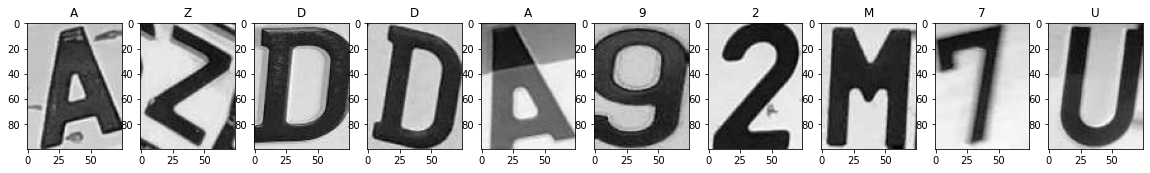

In [9]:
plot_images(images, labels, 10)

# PCA

In [39]:
from sklearn.decomposition import PCA
# Running the following on a subset of the images
new_images = images[:5000]

In [ ]:
%%time
pca = PCA(n_components=25, svd_solver="full")
pca.fit(new_images)
images_pca = pca.transform(new_images)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

The cumulative explained variance begins to level off with around 25 components. For this reason we believe that 25 dimensions are adequate to represent our data.

## Randomized PCA

In [ ]:
%%time
pca_rand = PCA(n_components=25, svd_solver='randomized')
pca_rand.fit(new_images)
images_pca_rand = pca_rand.transform(new_images)

In [19]:
# For each item in array, find the nearest neighbor and see if it is of the same label
def get_nearest_neighbor_accuracy(arr, labels):
    num_correct = 0
    for i in range(len(arr) - 1):
        min_distance_index = -1
        min_distance = np.inf
        for j in range(i + 1, len(arr)):
            distance = np.linalg.norm(arr[i] - arr[j])
            if distance < min_distance:
                min_distance = distance
                min_distance_index = j

        if labels[i] == labels[min_distance_index]:
            num_correct += 1
    return num_correct / arr.shape[0]

In [37]:
%%time
get_nearest_neighbor_accuracy(images_pca, labels)

CPU times: user 3.32 s, sys: 51 ms, total: 3.37 s
Wall time: 3.48 s


0.588

In [38]:
%%time
get_nearest_neighbor_accuracy(images_pca_rand, labels)

CPU times: user 3.08 s, sys: 50.8 ms, total: 3.13 s
Wall time: 3.16 s


0.588